In [329]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from torch.nn import BatchNorm2d
from torchvision.datasets import CIFAR10
from torch.autograd import Variable
from PIL import Image
import requests
import io


In [330]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [331]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [332]:
train_set = datasets.CIFAR10(root='CIFAR10', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.CIFAR10(root='CIFAR10', train=False,download=True,transform=transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [333]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [334]:
loaded_model = CNN()
loaded_model.load_state_dict(torch.load('fold_3_model.pth'))
loaded_model.eval()

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

# Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

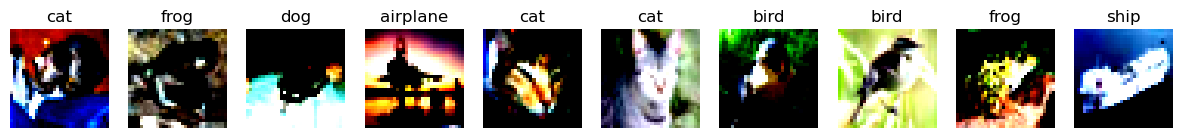

[3, 6, 5, 0, 3, 3, 2, 2, 6, 8]


In [358]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
image_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

dataiter = iter(image_loader)
plt.figure(figsize=(15, 1.5))
selected = []
for i in range(10):
    images, labels = next(dataiter)
    img_np = images[0].numpy()
    selected.append(labels[0].item())
    plt.subplot(1, 10, i + 1)
    plt.imshow(np.transpose(img_np, (1, 2, 0)))
    plt.title(class_names[labels[0].item()])
    plt.axis('off')

plt.show()
print(selected)

# Section II: Adversarial Attack

## Fast Gradient Sign Method (FGSM):


In [359]:
for images, labels in test_loader:
    img = transforms.ToPILImage()(images[0])
    break

In [360]:
image_tensor = transform(img)
image_tensor = image_tensor.unsqueeze(0)

In [361]:
img_variable = Variable(image_tensor,requires_grad=True)
img_variable

tensor([[[[-0.2513, -0.2513, -0.1657,  ...,  0.7248,  0.5022,  0.5022],
          [-0.0972, -0.0116,  0.0569,  ...,  1.5468,  0.7248,  0.6563],
          [-0.0116, -0.0116,  0.0569,  ...,  1.5468,  0.7248,  0.5707],
          ...,
          [ 0.5707,  0.5707,  0.6563,  ...,  0.0569, -0.0972, -0.1657],
          [ 0.5022,  0.5707,  0.6563,  ..., -0.0116, -0.2513, -0.2513],
          [ 0.4337,  0.5022,  0.5707,  ..., -0.0972, -0.2513, -0.3198]],

         [[-1.4405, -1.4405, -1.3704,  ..., -0.8978, -1.1253, -1.0553],
          [-1.2129, -1.2129, -1.1253,  ..., -0.4251, -0.9678, -0.8102],
          [-1.1253, -1.2129, -1.1253,  ..., -0.7402, -1.0553, -0.8102],
          ...,
          [-0.7402, -0.8102, -0.7402,  ..., -1.4405, -1.5980, -1.5980],
          [-0.8978, -0.8102, -0.7402,  ..., -1.5105, -1.7556, -1.6681],
          [-0.9678, -0.9678, -0.8102,  ..., -1.5980, -1.7556, -1.7556]],

         [[ 1.7163,  1.7163,  1.7860,  ...,  1.6291,  1.4722,  1.4722],
          [ 2.0125,  1.9428,  

In [371]:
img_variable = F.interpolate(img_variable.view(1, 3, 32, 32), size=(32, 32), mode='bilinear', align_corners=False)
img_variable = img_variable.view(1, 3, 32, 32)

In [372]:
output = loaded_model(img_variable)
label_idx = torch.max(output.data, 1)[1][0]
print("Predicted Label Index:", label_idx)

Predicted Label Index: tensor(8)


In [373]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
x_pred = class_names[label_idx.item()]
print("Predicted Label:", x_pred)

Predicted Label: ship


In [374]:
output_probs = F.softmax(output, dim=1)
x_pred_prob = round(torch.max(output_probs.data, 1)[0][0].item() * 100, 4)
print("Predicted Probability:", x_pred_prob)


Predicted Probability: 44.1589


In [375]:
y_true = 8
target = torch.tensor([y_true], dtype=torch.long)
print(target)

tensor([8])


In [376]:
output = torch.randn(1, 10, requires_grad=True, dtype=torch.float32)  
target = torch.tensor([y_true], dtype=torch.long)  
loss = torch.nn.CrossEntropyLoss()
loss_cal = loss(output, target)
loss_cal.backward(retain_graph=True)

In [377]:
eps = 0.02
img_variable = Variable(img_variable, requires_grad=True)
output = loaded_model(img_variable)
loss_function = torch.nn.CrossEntropyLoss()
loss = loss_function(output, target)
loss.backward()
x_grad = torch.sign(img_variable.grad.data)
x_adversarial = img_variable.data + eps * x_grad
output_adv = loaded_model(x_adversarial)
x_adv_pred_idx = torch.argmax(output_adv.data)
x_adv_pred = class_names[x_adv_pred_idx.item()] 

op_adv_probs = F.softmax(output_adv, dim=1)
adv_pred_prob = round(torch.max(op_adv_probs.data, 1)[0][0].item() * 100, 4)

print("Adv Predicted Label:", x_adv_pred)
print("Adv Predicted Probability:", adv_pred_prob)

Adv Predicted Label: ship
Adv Predicted Probability: 41.8745


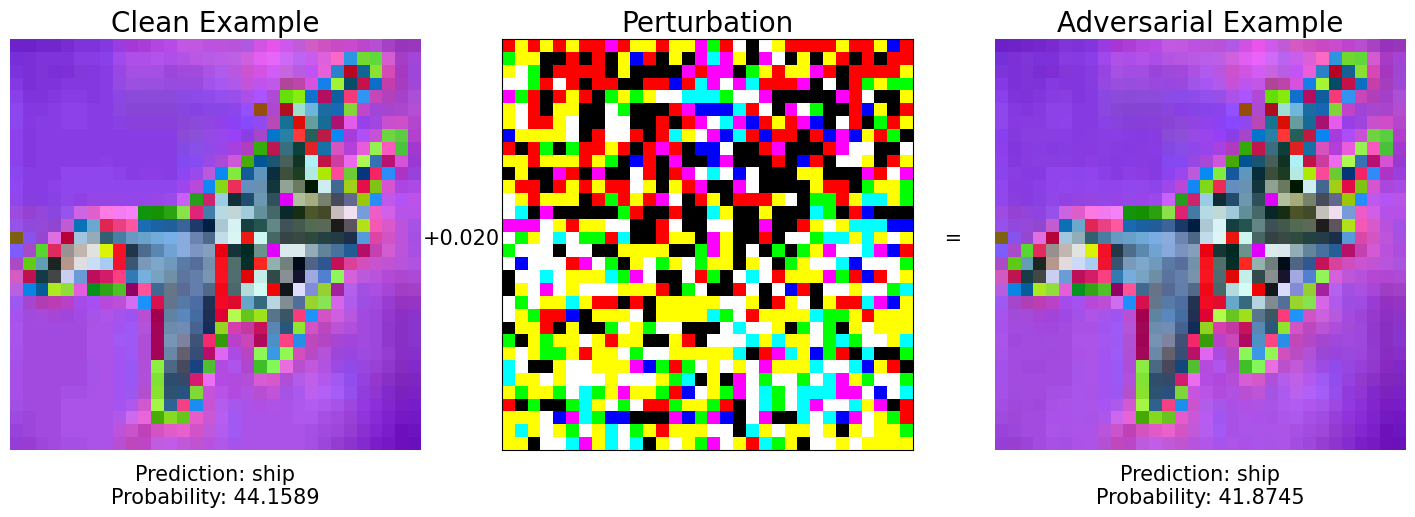

In [378]:
import numpy as np
import matplotlib.pyplot as plt

def visualize(x, x_adv, x_grad, epsilon, clean_pred, adv_pred, clean_prob, adv_prob):
    x = x.squeeze(0)
    x = x.mul(torch.FloatTensor(std).view(3, 1, 1)).add(torch.FloatTensor(mean).view(3, 1, 1)).numpy()
    x = np.transpose(x, (1, 2, 0))
    x = np.clip(x, 0, 1)

    x_adv = x_adv.squeeze(0)
    x_adv = x_adv.mul(torch.FloatTensor(std).view(3, 1, 1)).add(torch.FloatTensor(mean).view(3, 1, 1)).numpy()
    x_adv = np.transpose(x_adv, (1, 2, 0))
    x_adv = np.clip(x_adv, 0, 1)

    x_grad = x_grad.squeeze(0).numpy()
    x_grad = np.transpose(x_grad, (1, 2, 0))
    x_grad = np.clip(x_grad, 0, 1)

    fig, ax = plt.subplots(1, 3, figsize=(18, 8))
    ax[0].imshow(x)
    ax[0].set_title('Clean Example', fontsize=20)
    ax[1].imshow(x_grad)
    ax[1].set_title('Perturbation', fontsize=20)
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[2].imshow(x_adv)
    ax[2].set_title('Adversarial Example', fontsize=20)
    ax[0].axis('off')
    ax[2].axis('off')
    ax[0].text(1.1, 0.5, "+{:.3f}".format(epsilon), size=15, ha="center", transform=ax[0].transAxes)
    ax[0].text(0.5, -0.13, "Prediction: {}\nProbability: {:.4f}".format(clean_pred, clean_prob),
               size=15, ha="center", transform=ax[0].transAxes)
    ax[1].text(1.1, 0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)
    ax[2].text(0.5, -0.13, "Prediction: {}\nProbability: {:.4f}".format(adv_pred, adv_prob),
               size=15, ha="center", transform=ax[2].transAxes)
    plt.show()

visualize(image_tensor, x_adversarial, x_grad, eps, x_pred, x_adv_pred, x_pred_prob, adv_pred_prob)

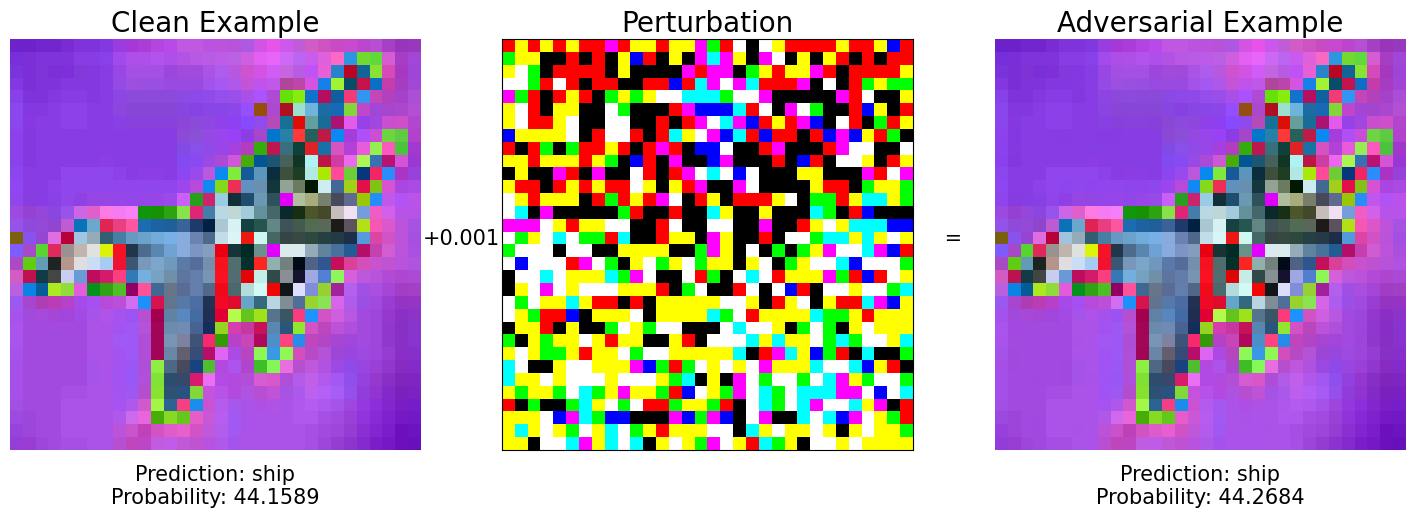

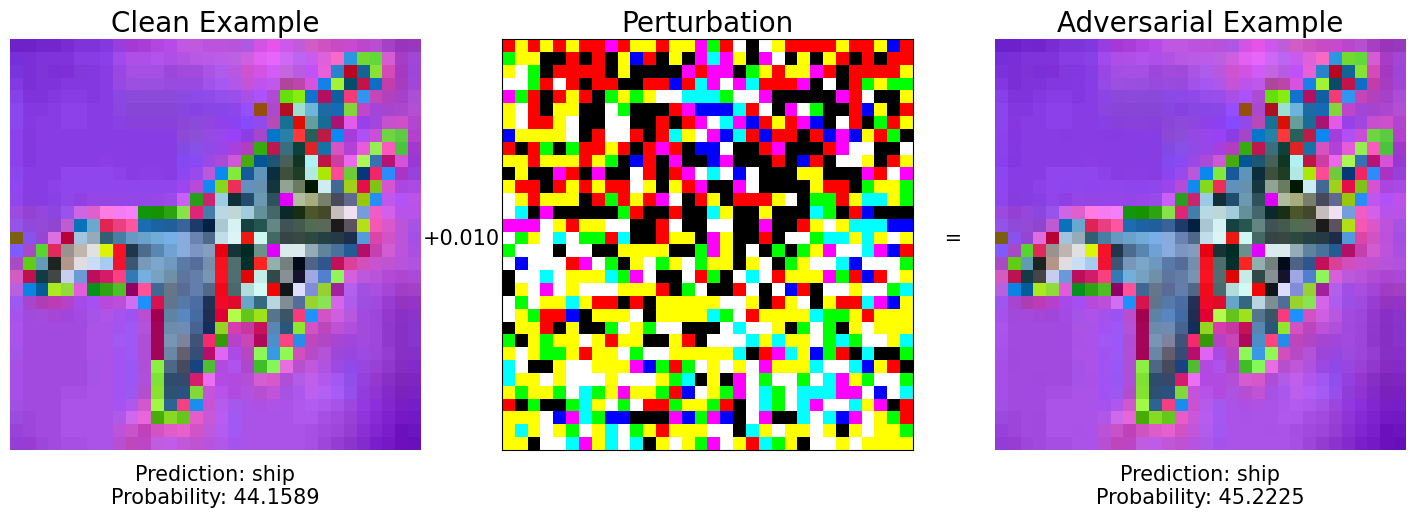

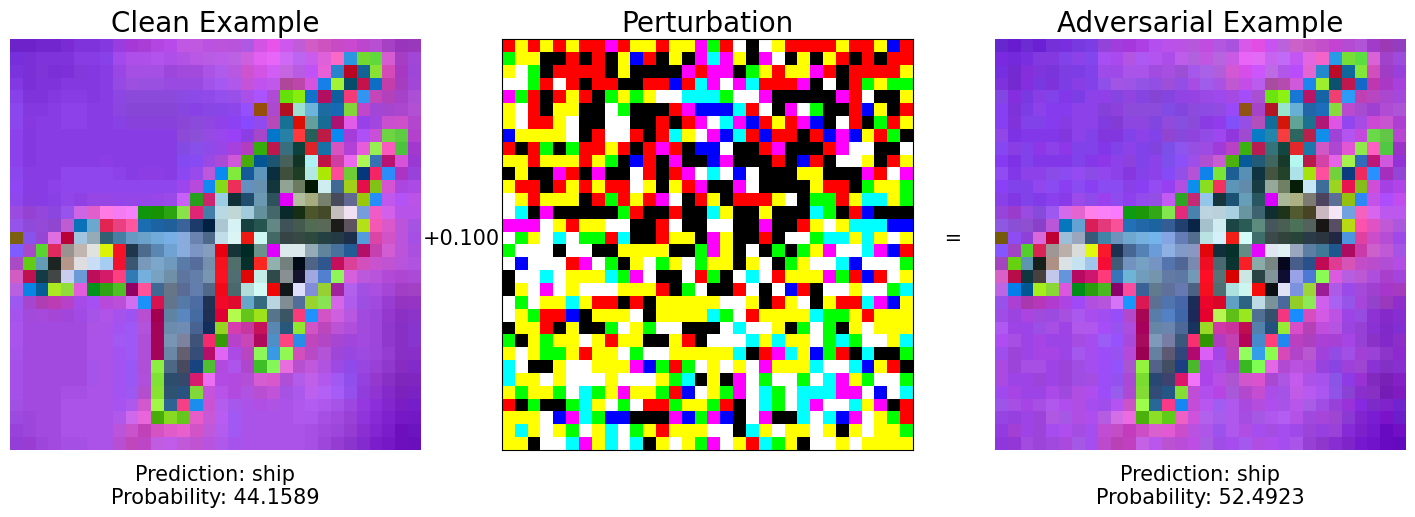

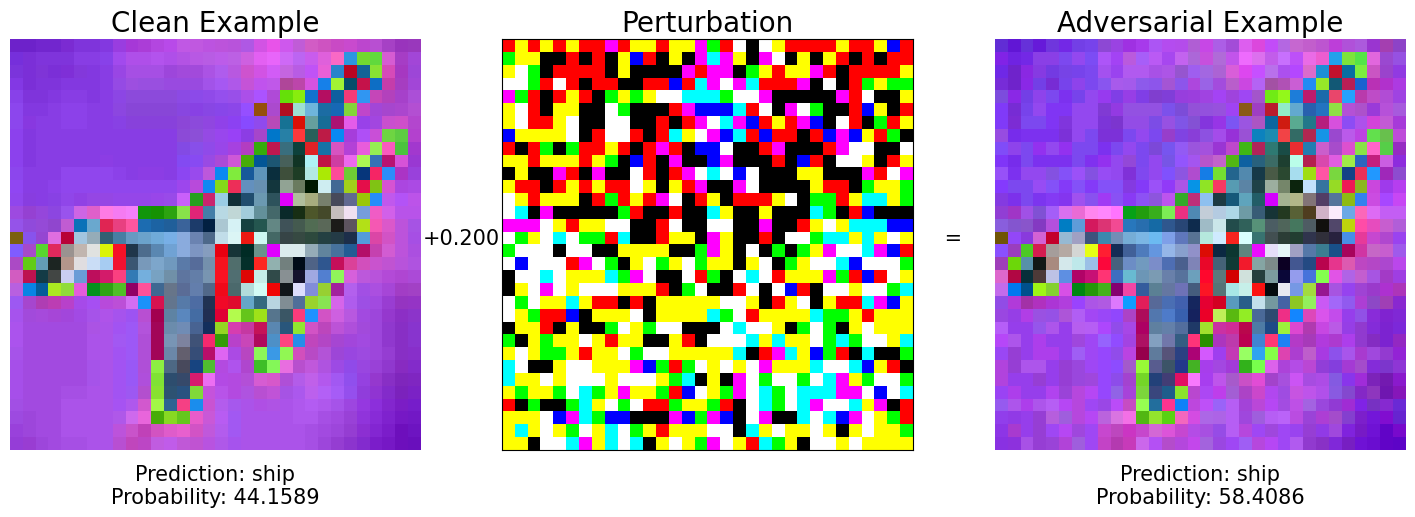

In [379]:
epsilons = [0.001, 0.01, 0.1, 0.2] 
loaded_model.eval()
x_grad = torch.sign(img_variable.grad.data)

for eps in epsilons:
    x_adversarial = img_variable.data - eps * x_grad   
    output_adv = loaded_model(x_adversarial)
    x_adv_pred_idx = torch.max(output_adv.data, 1)[1][0]

    op_adv_probs = F.softmax(output_adv, dim=1)
    adv_pred_prob = round(op_adv_probs.data[0, x_adv_pred_idx].item() * 100, 4)
    x_adv_pred = class_names[x_adv_pred_idx]
    
    visualize(image_tensor, x_adversarial, x_grad, eps, x_pred, x_adv_pred, x_pred_prob, adv_pred_prob)


In [ ]:
'''
The FSGM methods does not show efficient for adversarial attack in this dataset.
The method BIM presents an better results.
'''

# Basic Iterative Method (BIM)

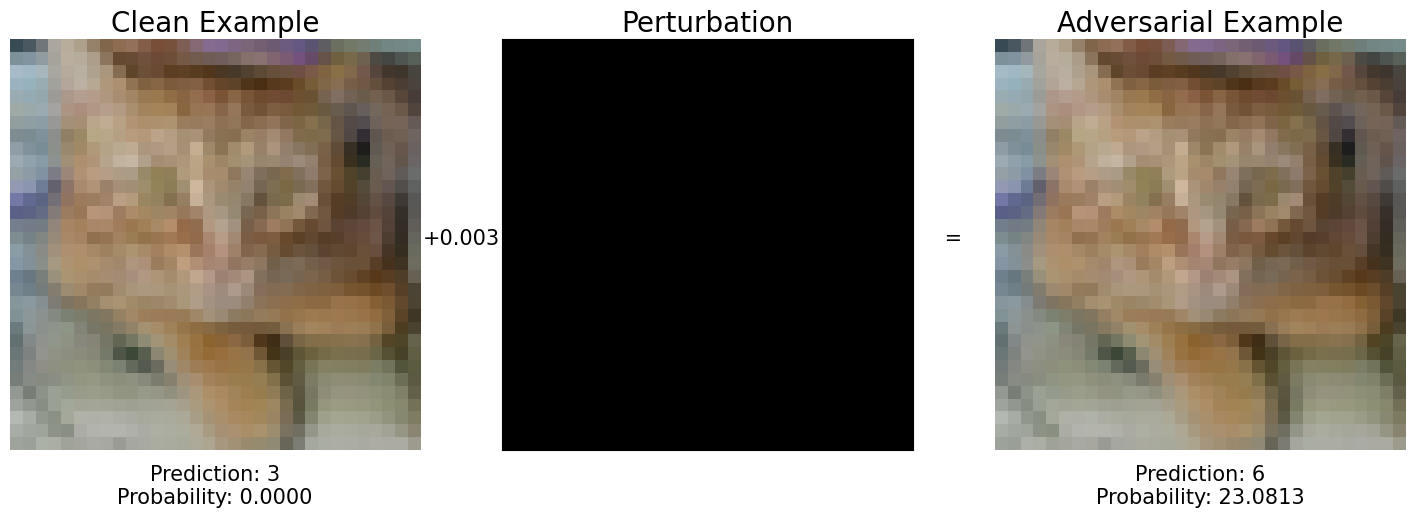

In [380]:
loaded_model.eval()

for images, labels in test_loader:
    break

img = images[0].unsqueeze(0)
label = labels[0]

img_variable = Variable(img, requires_grad=True)

y_true = Variable(torch.LongTensor([label]), requires_grad=False)

epsilon = 0.0025
num_steps = 5
alpha = 0.025

for i in range(num_steps):
    output = loaded_model(img_variable)
    loss = torch.nn.CrossEntropyLoss()
    loss_cal = loss(output, y_true)
    loss_cal.backward()

    x_grad = alpha * torch.sign(img_variable.grad.data)

    adv_temp = img_variable.data + x_grad
    total_grad = adv_temp - img
    total_grad = torch.clamp(total_grad, -epsilon, epsilon)
    x_adv = img + total_grad

    img_variable.data = x_adv

output_adv = loaded_model(img_variable)

x_adv_pred_idx = torch.max(output_adv.data, 1)[1][0]
x_adv_pred_prob = round(F.softmax(output_adv, dim=1).data[0][x_adv_pred_idx].item() * 100, 4)

visualize(img, img_variable.data, total_grad, epsilon, label.item(), x_adv_pred_idx, 0, x_adv_pred_prob)
